# Proyek Klasifikasi Gambar: Shoe vs Sandal vs Boot Dataset
- **Nama:** Khansa Fakhirah Rifli
- **Email:** khansa.fr9@gmail.com
- **ID Dicoding:** MC009D5X2458

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [2]:
import os
import shutil
import random

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import Callback

## Data Preparation

### Data Loading

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"khansarifli","key":"b3f999fde24539ecf9062c5b2f8efb08"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images
!unzip -q "shoe-vs-sandal-vs-boot-dataset-15k-images.zip"

Dataset URL: https://www.kaggle.com/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images
License(s): copyright-authors


### Menampilkan jumlah dan resolusi gambar

In [6]:
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            image_files = os.listdir(subdir_path)
            num_images = len(image_files)
            print(f"{subdir}: {num_images} images")
            total_images += num_images

            for img_file in image_files:
                img_path = os.path.join(subdir_path, img_file)
                try:
                    with Image.open(img_path) as img:
                        unique_sizes.add(img.size)
                except:
                    pass

    print(f"Unique Image Sizes: {unique_sizes}")
    print(f"\nTotal Images: {total_images}")

In [7]:
print_images_resolution("Shoe vs Sandal vs Boot Dataset")

Boot: 5000 images
Shoe: 5000 images
Sandal: 5000 images
Unique Image Sizes: {(136, 102), (135, 102)}

Total Images: 15000


### Data Preprocessing

#### Split Dataset

In [8]:
# Set parameter
base_dir = "Shoe vs Sandal vs Boot Dataset"
split_base = "split_dataset"
img_size = (224, 224)
batch_size = 32

In [9]:
# Membuat folder split train/val/test
for folder in ['train', 'val', 'test']:
    os.makedirs(os.path.join(split_base, folder), exist_ok=True)

for folder in ['train', 'val', 'test']:
    for class_name in os.listdir(base_dir):
        os.makedirs(os.path.join(split_base, folder, class_name), exist_ok=True)

In [10]:
# Membagi gambar ke folder train/val/test (70/15/15)
for class_name in os.listdir(base_dir):
    class_folder = os.path.join(base_dir, class_name)
    image_files = os.listdir(class_folder)
    random.shuffle(image_files)

    num_train = int(len(image_files) * 0.7)
    num_val = int(len(image_files) * 0.15)
    num_test = len(image_files) - num_train - num_val

    train_files = image_files[:num_train]
    val_files = image_files[num_train:num_train+num_val]
    test_files = image_files[num_train+num_val:]

    for file in train_files:
        shutil.copy(os.path.join(class_folder, file), os.path.join(split_base, 'train', class_name, file))
    for file in val_files:
        shutil.copy(os.path.join(class_folder, file), os.path.join(split_base, 'val', class_name, file))
    for file in test_files:
        shutil.copy(os.path.join(class_folder, file), os.path.join(split_base, 'test', class_name, file))

In [11]:
# Load data menggunakan ImageDataGenerator
train_dir = os.path.join(split_base, 'train')
val_dir = os.path.join(split_base, 'val')
test_dir = os.path.join(split_base, 'test')

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
)

class_names = list(train_generator.class_indices.keys())

Found 10500 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.


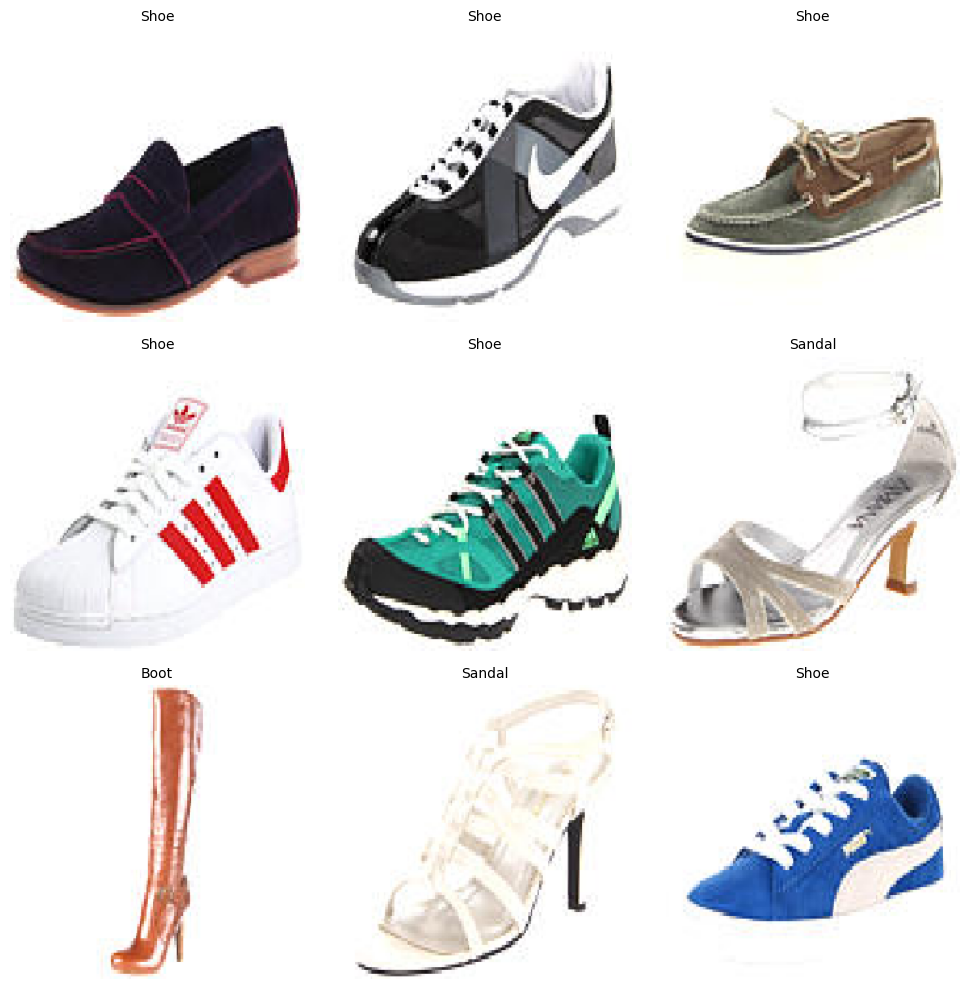

In [12]:
# Visualisasi beberapa gambar dari train_generator
def visualize_generator_samples(generator, class_names, num_images=9):
    images, labels = next(generator)

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        label_index = np.argmax(labels[i])
        plt.title(class_names[label_index], fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_generator_samples(train_generator, class_names)

## Modelling

In [13]:
# Membuat model CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Membuat callback untuk menghentikan training jika akurasi >= 95%
class TerminateOnBaseline(Callback):
    def __init__(self, monitor='accuracy', baseline=0.95):
        super(TerminateOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = baseline

    def on_epoch_end(self, epoch, logs=None):
        if logs.get(self.monitor) is not None and logs.get(self.monitor) >= self.baseline:
            print(f"\nTarget {self.monitor} {self.baseline*100:.2f}% tercapai. Training dihentikan pada epoch {epoch+1}.")
            self.model.stop_training = True

stop_training_callback = TerminateOnBaseline(monitor='accuracy', baseline=0.95)

In [16]:
# Training model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[stop_training_callback],
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


329/329 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - accuracy: 0.7583 - loss: 0.6265 - val_accuracy: 0.9431 - val_loss: 0.1704
Epoch 2/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.9443 - loss: 0.1680 - val_accuracy: 0.9516 - val_loss: 0.1381
Epoch 3/50
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9668 - loss: 0.0984
Target accuracy 95.00% tercapai. Training dihentikan pada epoch 3.
329/329 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - accuracy: 0.9667 - loss: 0.0985 - val_accuracy: 0.9560 - val_loss: 0.1306


## Evaluasi dan Visualisasi

In [17]:
# Evaluasi model
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
test_loss, test_acc = model.evaluate(test_generator)

print(f"Training Accuracy   : {train_acc * 100:.2f}%")
print(f"Validation Accuracy : {val_acc * 100:.2f}%")
print(f"Testing Accuracy    : {test_acc * 100:.2f}%")

71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9492 - loss: 0.1596
Training Accuracy   : 96.56%
Validation Accuracy : 95.60%
Testing Accuracy    : 95.38%


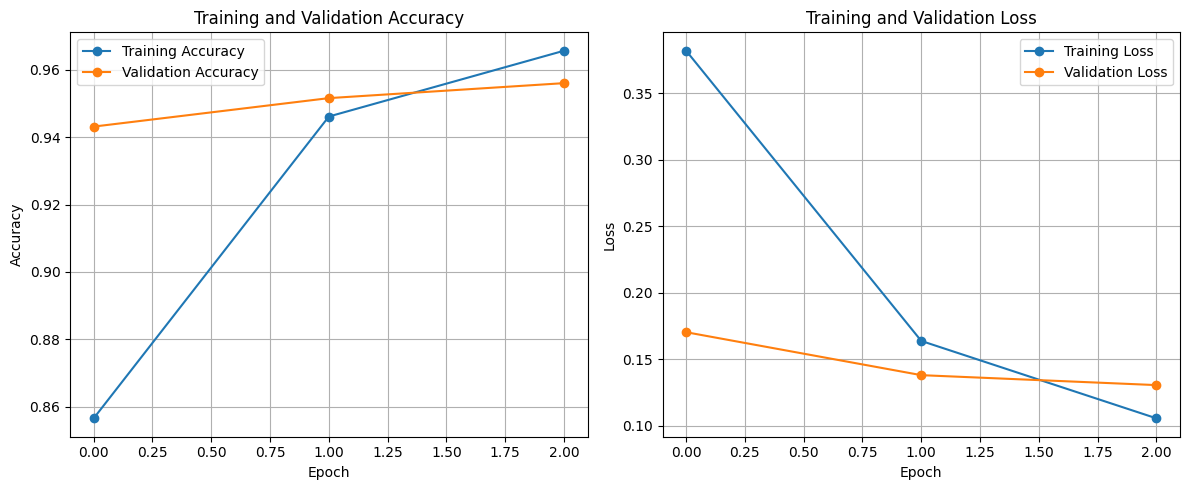

In [18]:
# Plot akurasi dan loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Insight:**
- **Akurasi:**
  - Training dan validation accuracy sama-sama meningkat seiring bertambahnya epoch.
  - Tidak ada jarak yang besar antara training dan validation accuracy, menunjukkan model tidak mengalami overfitting.

- **Loss:**
  - Training dan validation loss menurun secara konsisten seiring waktu.
  - Validation loss stabil mendekati training loss, menandakan generalisasi model berjalan baik.

- **Kesimpulan:**
  - Model belajar dengan stabil.
  - Tidak ada tanda-tanda overfitting atau underfitting yang signifikan.

In [19]:
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2250 images belonging to 3 classes.


              precision    recall  f1-score   support

        Boot       0.99      0.94      0.96       750
      Sandal       0.94      0.96      0.95       750
        Shoe       0.94      0.96      0.95       750

    accuracy                           0.95      2250
   macro avg       0.95      0.95      0.95      2250
weighted avg       0.95      0.95      0.95      2250



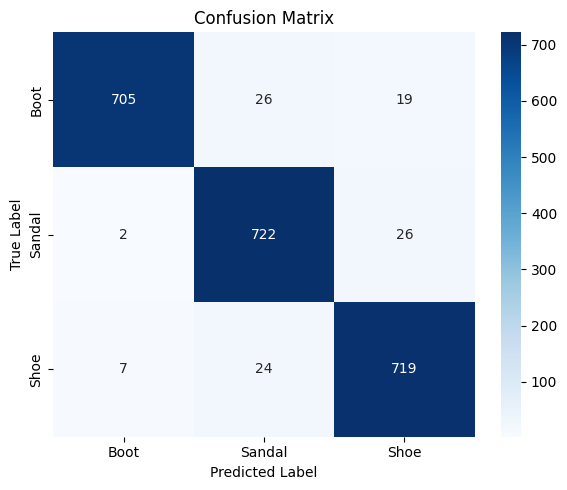

In [20]:
# Predict semua data
y_probs = model.predict(test_generator, verbose=0)
y_pred = np.argmax(y_probs, axis=1)

# Ground truth
y_true = test_generator.classes

# Confusion Matrix & Classification Report
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

**Insight:**


- **Akurasi Umum:** Akurasi keseluruhan model adalah 97%, menunjukkan performa yang sangat baik dalam mengklasifikasikan gambar.

- **Evaluasi Per Kelas:**
  - Boot diklasifikasikan hampir sempurna (Precision dan Recall 98%).
  - Sandal sedikit lebih banyak salah prediksi dibanding Boot (Recall 96%)
  - Shoe memiliki Precision terendah, namun Recall tetap tinggi.

- **Rata-rata Skor:**
  - Macro Average: 0.97
  - Weighted Average: 0.97

- **Kesimpulan:**
Model sudah sangat baik dalam klasifikasi. Untuk peningkatan, dapat dilakukan fine-tuning atau menambahkan data augmentation untuk memperbaiki performa pada kelas Sandal dan Shoe.



## Konversi Model

In [21]:
#Buat folder
os.makedirs('saved_model', exist_ok=True)
os.makedirs('tflite', exist_ok=True)
os.makedirs('tfjs_model', exist_ok=True)

In [22]:
save_path = 'saved_model/'
tf.saved_model.save(model, save_path)

In [23]:
# Mengonversi model ke format TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

# Simpan label.txt (mapping label kelas)
class_names = ['Boot', 'Sandal', 'Shoe']  # Disesuaikan dengan model kamu
with open('tflite/label.txt', 'w') as f:
    for label in class_names:
        f.write(f"{label}\n")

Saved artifact at '/tmp/tmptftelr9h'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  135844306490896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135844306493968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135844306494736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135844306491664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135844306493584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135844306495312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135844306490512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135844306495696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135844306498384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135844306496656: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [24]:
# Simpan model ke TensorFlow.js
tfjs.converters.save_keras_model(model, 'tfjs_model')

failed to lookup keras version from the file,
    this is likely a weight only file


In [25]:
import tensorflowjs as tfjs

# Mengonversi model ke format TensorFlow.js
tfjs.converters.save_keras_model(model, 'model_tfjs')

failed to lookup keras version from the file,
    this is likely a weight only file


## Inference (Optional)

In [29]:
# Load SavedModel
loaded_model = tf.saved_model.load('saved_model')
infer = loaded_model.signatures["serving_default"]

# Label kelas
class_names = ['Boot', 'Sandal', 'Shoe']

# Fungsi Inference
def infer_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Prediksi
    predictions = infer(tf.constant(img_array))['output_0']
    predicted_class = np.argmax(predictions, axis=1)
    predicted_label = class_names[predicted_class[0]]

    # Tampilkan hasil
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

    return predicted_label

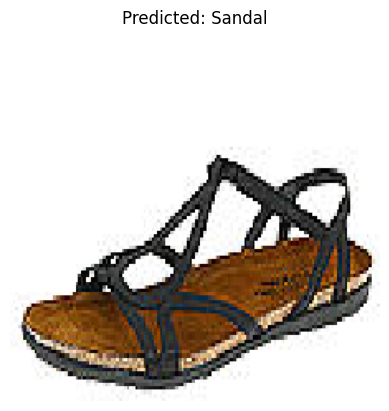

'Sandal'

In [32]:
# Contoh penggunaan
img_path = 'Shoe vs Sandal vs Boot Dataset/Sandal/Sandal (1118).jpg'
infer_image(img_path)

In [31]:
 !pip freeze requirements.txt

absl-py==1.4.0
accelerate==1.5.2
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.5
ale-py==0.10.2
altair==5.5.0
annotated-types==0.7.0
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.1
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.4.21.0.37.6
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==2.1.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blosc2==3.3.1
bokeh==3.6.3
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
CacheControl==0.14.2
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.1.31
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.89
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confect